In [1]:
library(tidyverse)
library(ROCR)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.5
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



setwd("D:/OneDrive - Diesel Analytics/Professional/Clients/FinanceOrganization")
library(tidyverse)
library(lubridate)

read_csv("prosperLoanData.csv") %>%
filter(LoanOriginationDate < ymd(20100101) & LoanStatus != "Cancelled") %>%
write_csv("prosperLoanData_Excerpt.csv")

In [2]:
setwd("D:/OneDrive - Diesel Analytics/Professional/Clients/FinanceOrganization")
prosperLoanData_Excerpt <- read_csv("prosperLoanData_Excerpt_Revised.csv")

Parsed with column specification:
cols(
  .default = col_integer(),
  ListingKey = col_character(),
  ListingCreationDate = col_datetime(format = ""),
  CreditGrade = col_character(),
  LoanStatus = col_character(),
  ClosedDate = col_datetime(format = ""),
  BorrowerAPR = col_double(),
  BorrowerRate = col_double(),
  LenderYield = col_double(),
  EstimatedEffectiveYield = col_double(),
  EstimatedLoss = col_double(),
  EstimatedReturn = col_double(),
  `ProsperRating (Alpha)` = col_character(),
  BorrowerState = col_character(),
  Occupation = col_character(),
  EmploymentStatus = col_character(),
  IsBorrowerHomeowner = col_logical(),
  CurrentlyInGroup = col_logical(),
  GroupKey = col_character(),
  DateCreditPulled = col_datetime(format = ""),
  FirstRecordedCreditLine = col_datetime(format = "")
  # ... with 24 more columns
)
See spec(...) for full column specifications.


In [3]:
df <- problems(prosperLoanData_Excerpt)
write_csv(df,"problems.csv")
getwd()

[1] "D:/OneDrive - Diesel Analytics/Professional/Clients/FinanceOrganization"

In [4]:
prosper_data <-
    prosperLoanData_Excerpt %>%
    filter(!is.na(BankcardUtilization) & !is.na(CreditScoreRangeLower) & !is.na(CreditScoreRangeUpper) & !is.na(DelinquenciesLast7Years)) %>%
    select(ListingKey, LoanStatus, IsBorrowerHomeowner, CreditScoreRangeLower, CreditScoreRangeUpper, 
           DelinquenciesLast7Years, BankcardUtilization, IncomeRange
    ) %>%
    mutate(
        AvgScore = round((CreditScoreRangeLower + CreditScoreRangeUpper)/2,0),
        CreditScoreCategory =
            ifelse(AvgScore >= 750, "Excellent",
            ifelse(AvgScore >= 700 & AvgScore <= 749, "Good",
            ifelse(AvgScore >= 650 & AvgScore <= 699, "Fair",
            ifelse(AvgScore >= 550 & AvgScore <= 649, "Poor",
            ifelse(AvgScore < 550, "Bad", 
            ifelse(is.na(CreditScoreRangeLower) | is.na(CreditScoreRangeUpper),"Unknown","Unknown")))))),
        TerminalStatus = ifelse(LoanStatus == "Completed", 1,0),
        DelinquencyCategory = 
            ifelse(DelinquenciesLast7Years <= 7, "Good",
            ifelse(DelinquenciesLast7Years > 7 & DelinquenciesLast7Years <= 14, "Ok", "Bad")),
        BankcardUtilizationCategory = ifelse(BankcardUtilization > 0.3, "Bad", "Good")
    ) %>%
    select(
        ListingKey, IsBorrowerHomeowner, CreditScoreCategory, BankcardUtilizationCategory, 
        DelinquencyCategory, IncomeRange, TerminalStatus
    ) %>%
    mutate_all(factor)

In [5]:
prosper_traindata <- sample_frac(prosper_data, 0.8)
prosper_testdata <- anti_join(prosper_data, prosper_traindata, by=c("ListingKey", "ListingKey"))

In [6]:
PredictDefaultsFormula <-
    as.formula(
        "TerminalStatus ~ 
            IsBorrowerHomeowner + CreditScoreCategory + BankcardUtilizationCategory + DelinquencyCategory + IncomeRange"
    )

DefaultsModel <- glm(PredictDefaultsFormula, family = binomial, data = prosper_traindata)

In [7]:
summary(DefaultsModel)


Call:
glm(formula = PredictDefaultsFormula, family = binomial, data = prosper_traindata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2464  -1.2847   0.6647   0.9641   1.6668  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.95269    0.12736  -7.480 7.43e-14 ***
IsBorrowerHomeownerTRUE         -0.52168    0.03656 -14.270  < 2e-16 ***
CreditScoreCategoryExcellent     2.27847    0.08749  26.044  < 2e-16 ***
CreditScoreCategoryFair          1.21657    0.07548  16.117  < 2e-16 ***
CreditScoreCategoryGood          1.60224    0.08319  19.260  < 2e-16 ***
CreditScoreCategoryPoor          0.75055    0.07400  10.143  < 2e-16 ***
BankcardUtilizationCategoryGood -0.06349    0.03878  -1.637   0.1016    
DelinquencyCategoryGood          0.21026    0.05120   4.107 4.01e-05 ***
DelinquencyCategoryOk            0.09995    0.07112   1.405   0.1599    
IncomeRange$1-24,999             0.43559    0.10848

In [8]:
PredictDefaults <- predict(DefaultsModel, newdata = prosper_testdata, type = "response")
prosper_testdata <- cbind(prosper_testdata, PredictDefaults)

In [9]:
perf.data <- prediction(prosper_testdata$PredictDefaults, prosper_testdata$TerminalStatus)
perf <- performance(perf.data, measure = "auc")
AUC_Stat <- round(as.numeric(perf@y.values),2)

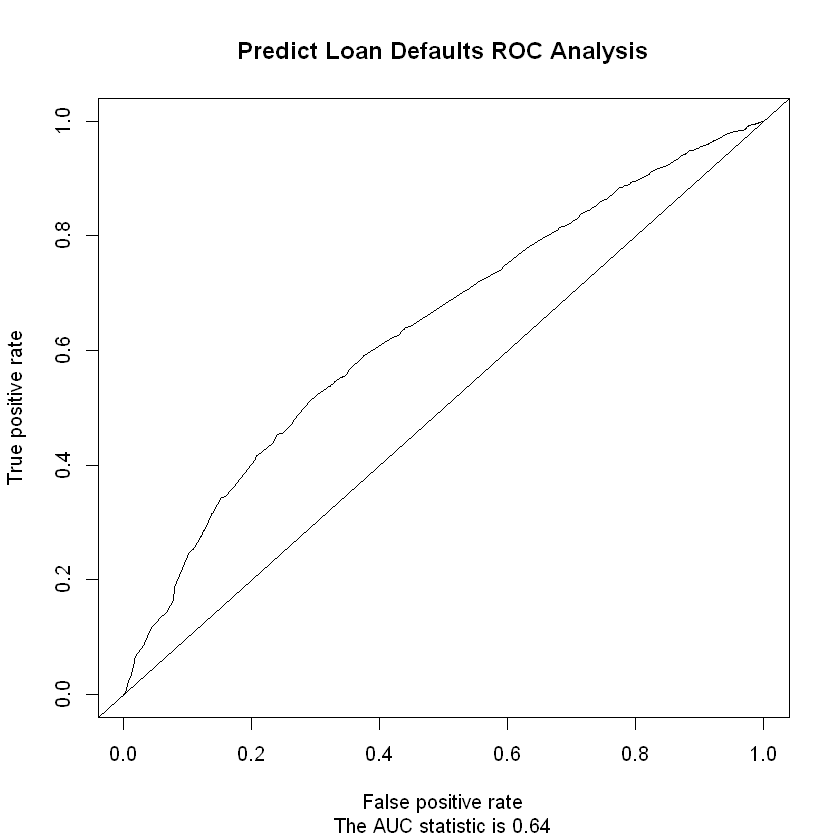

In [10]:
plot.data <- performance(perf.data, "tpr", "fpr")
main_title <- "Predict Loan Defaults ROC Analysis"
sub_title <- paste("The AUC statistic is", AUC_Stat, sep = " ")
plot(plot.data, main = main_title, sub = sub_title)
abline(a = 0, b = 1)